# Anime Recommendation System - Complete Walkthrough

Notebook này walkthrough toàn bộ pipeline của hệ thống recommendation:
1. Setup và Import
2. Tải Dataset từ MongoDB
3. Làm Sạch Dữ Liệu
4. Trực Quan Hóa
5. Chunking Dữ Liệu (Train/Test Split)
6. Train 4 Models (User-Based, Item-Based, Neural CF, Hybrid)
7. Đánh Giá 4 Models
8. Demo Recommendations


## 1. Setup và Import Libraries

In [39]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from collections import defaultdict
import random
import torch
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully")

Libraries imported successfully


In [40]:
# Import models from backend
import sys
sys.path.insert(0, './backend')

from ml.models.user_based import UserBasedCF
from ml.models.item_based import ItemBasedCF
from ml.models.neural_cf import NeuralCF
from ml.models.hybrid import HybridWeightedCF
from ml.training.evaluate import evaluate_model, compare_models

print("Models imported successfully")

Models imported successfully


In [41]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print(f"Random seeds set to {SEED}")

Random seeds set to 42


## 2. Tải Dataset từ MongoDB

Dataset: **Kaggle Anime Recommendation Database 2020**
- Source: hernan4444/anime-recommendation-database-2020
- Ratings: 3 triệu (limited)
- Animes: ~17,000


In [42]:
# Connect to MongoDB
MONGODB_URI = 'mongodb://localhost:27017/'
MONGODB_DB = 'anime_recommendation'

try:
    client = MongoClient(MONGODB_URI, serverSelectionTimeoutMS=5000)
    client.server_info()  # Test connection
    db = client[MONGODB_DB]
    print(f"Connected to MongoDB: {MONGODB_DB}")
except Exception as e:
    print(f"✗ Could not connect to MongoDB: {e}")
    print("\nMake sure:")
    print("  1. MongoDB is running at localhost:27017")
    print("  2. Database has data (run: python backend/scripts/import_data.py)")
    raise

Connected to MongoDB: anime_recommendation


In [43]:
# Load ratings data
print("Loading ratings from MongoDB...")
ratings_cursor = db.ratings.find({}, {
    '_id': 0,
    'user_id': 1,
    'anime_id': 1,
    'rating': 1
})
ratings_data = list(ratings_cursor)

print(f"Loaded {len(ratings_data):,} ratings")

Loading ratings from MongoDB...
Loaded 3,000,003 ratings


In [44]:
# Load animes data
print("Loading animes from MongoDB...")
animes_cursor = db.animes.find({})
animes_data = list(animes_cursor)

# Create anime lookup dict
anime_dict = {anime['mal_id']: anime for anime in animes_data}

print(f"Loaded {len(animes_data):,} animes")

Loading animes from MongoDB...
Loaded 16,214 animes


In [45]:
# Display dataset statistics
print("="*60)
print("DATASET STATISTICS")
print("="*60)
print(f"Total Ratings: {len(ratings_data):,}")
print(f"Total Animes: {len(animes_data):,}")
print(f"Unique Users: {len(set([r['user_id'] for r in ratings_data])):,}")
print(f"Unique Animes Rated: {len(set([r['anime_id'] for r in ratings_data])):,}")
print(f"Rating Range: [{min(r['rating'] for r in ratings_data)}, {max(r['rating'] for r in ratings_data)}]")
print(f"Average Rating: {np.mean([r['rating'] for r in ratings_data]):.2f}")
print("="*60)

DATASET STATISTICS
Total Ratings: 3,000,003
Total Animes: 16,214
Unique Users: 16,131
Unique Animes Rated: 14,636
Rating Range: [1, 10]
Average Rating: 7.51


In [46]:
# Sample data
import pandas as pd

df_ratings = pd.DataFrame(ratings_data[:5])
print("Sample Ratings:")
display(df_ratings)

print("\nSample Animes:")
df_animes = pd.DataFrame([{
    'mal_id': a['mal_id'],
    'name': a['name'],
    'score': a.get('score', 0),
    'genres': a.get('genres', '')[:50]
} for a in animes_data[:5]])
display(df_animes)

Sample Ratings:


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9



Sample Animes:


,mal_id,name,score,genres
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space"
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen"
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ..."
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural"


## 3. Làm Sạch Dữ Liệu

Dataset đã được cleaned bởi import script (`backend/scripts/import_data.py`):

**Anime cleaning:**
- Remove duplicates on mal_id
- Fill missing synopsis và genres
- Convert score to numeric (fill NaN with 0)

**Rating cleaning:**
- Remove rating = -1 (not rated)
- Keep only ratings in [1, 10]
- Remove duplicates on (user_id, anime_id)
- Convert to int types

Chúng ta sẽ verify data đã clean:


In [47]:
# Verify rating range
ratings_values = [r['rating'] for r in ratings_data]
assert all(1 <= r <= 10 for r in ratings_values), "Invalid ratings found!"
print("All ratings in valid range [1, 10]")

# Check for duplicates
rating_pairs = [(r['user_id'], r['anime_id']) for r in ratings_data]
assert len(rating_pairs) == len(set(rating_pairs)), "Duplicate ratings found!"
print("No duplicate (user, anime) pairs")

# Check data types
assert all(isinstance(r['user_id'], int) for r in ratings_data[:100]), "user_id not int"
assert all(isinstance(r['anime_id'], int) for r in ratings_data[:100]), "anime_id not int"
assert all(isinstance(r['rating'], int) for r in ratings_data[:100]), "rating not int"
print("All fields have correct types")

print("\nData is clean and ready!")

All ratings in valid range [1, 10]
No duplicate (user, anime) pairs
All fields have correct types

Data is clean and ready!


## 4. Trực Quan Hóa Dữ Liệu

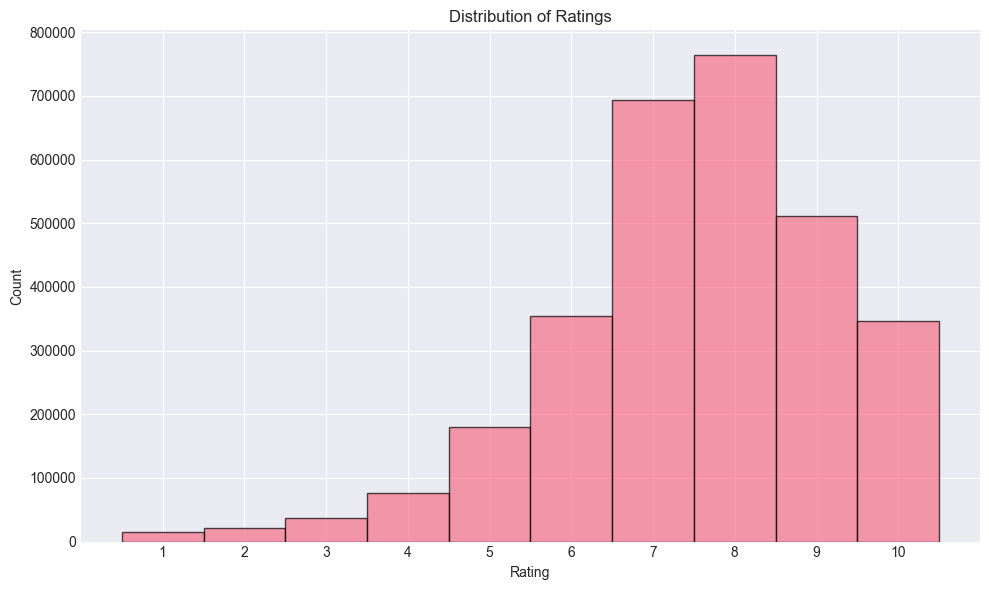

Mean Rating: 7.51
Median Rating: 8.00
Std Rating: 1.69


In [48]:
# 4.1. Rating distribution
fig, ax = plt.subplots(figsize=(10, 6))
ratings_values = [r['rating'] for r in ratings_data]
ax.hist(ratings_values, bins=10, range=(0.5, 10.5), edgecolor='black', alpha=0.7)
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
ax.set_title('Distribution of Ratings')
ax.set_xticks(range(1, 11))
plt.tight_layout()
plt.show()

print(f"Mean Rating: {np.mean(ratings_values):.2f}")
print(f"Median Rating: {np.median(ratings_values):.2f}")
print(f"Std Rating: {np.std(ratings_values):.2f}")

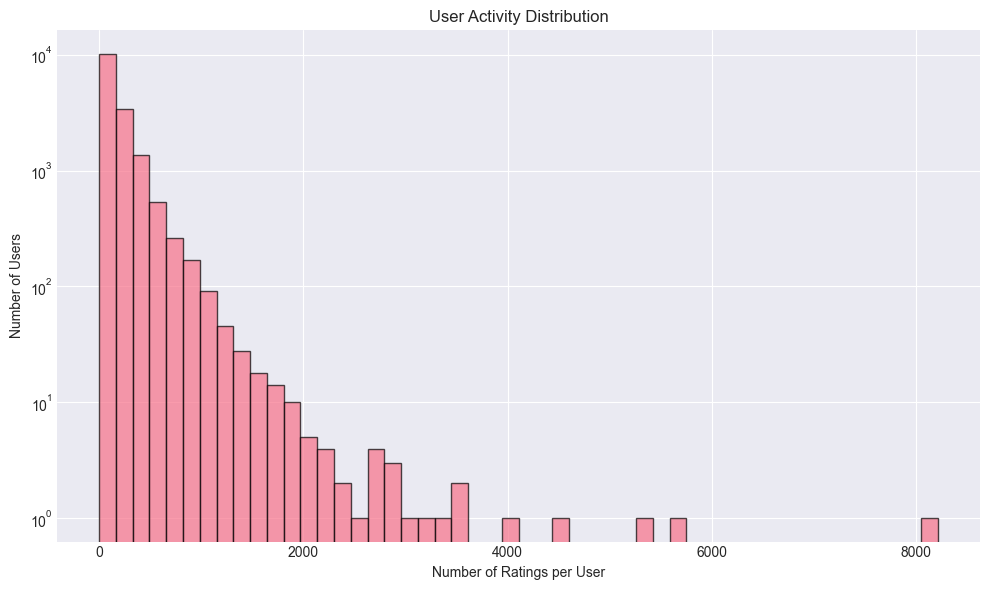

Mean ratings per user: 186.0
Median ratings per user: 112.0
Max ratings per user: 8,215


In [49]:
# 4.2. User activity (ratings per user)
user_counts = defaultdict(int)
for r in ratings_data:
    user_counts[r['user_id']] += 1

counts = list(user_counts.values())

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(counts, bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Number of Ratings per User')
ax.set_ylabel('Number of Users')
ax.set_title('User Activity Distribution')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

print(f"Mean ratings per user: {np.mean(counts):.1f}")
print(f"Median ratings per user: {np.median(counts):.1f}")
print(f"Max ratings per user: {max(counts):,}")

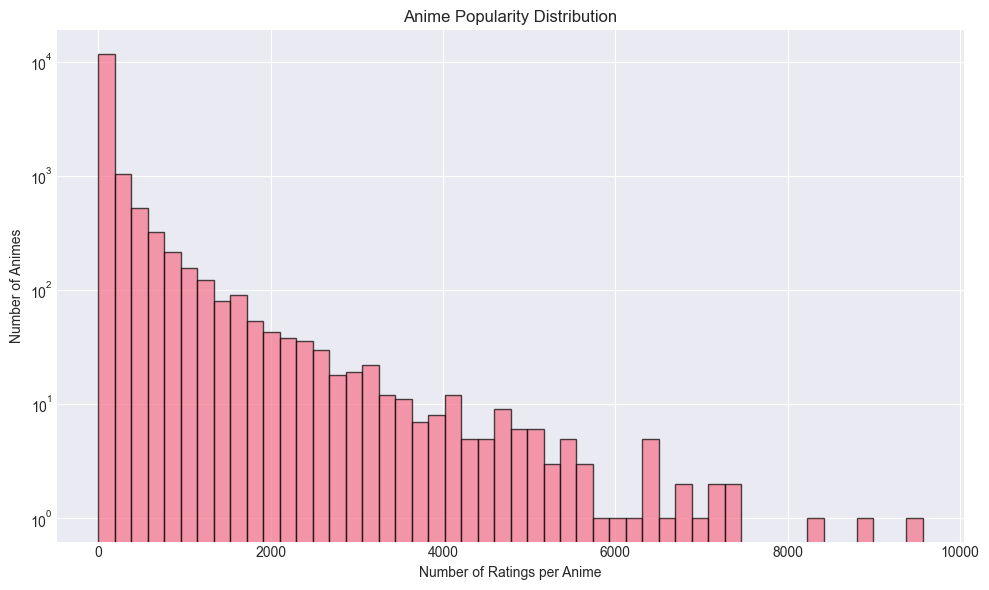

Mean ratings per anime: 205.0
Median ratings per anime: 22.0
Max ratings per anime: 9,567


In [50]:
# 4.3. Item popularity (ratings per anime)
anime_counts = defaultdict(int)
for r in ratings_data:
    anime_counts[r['anime_id']] += 1

counts = list(anime_counts.values())

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(counts, bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Number of Ratings per Anime')
ax.set_ylabel('Number of Animes')
ax.set_title('Anime Popularity Distribution')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

print(f"Mean ratings per anime: {np.mean(counts):.1f}")
print(f"Median ratings per anime: {np.median(counts):.1f}")
print(f"Max ratings per anime: {max(counts):,}")

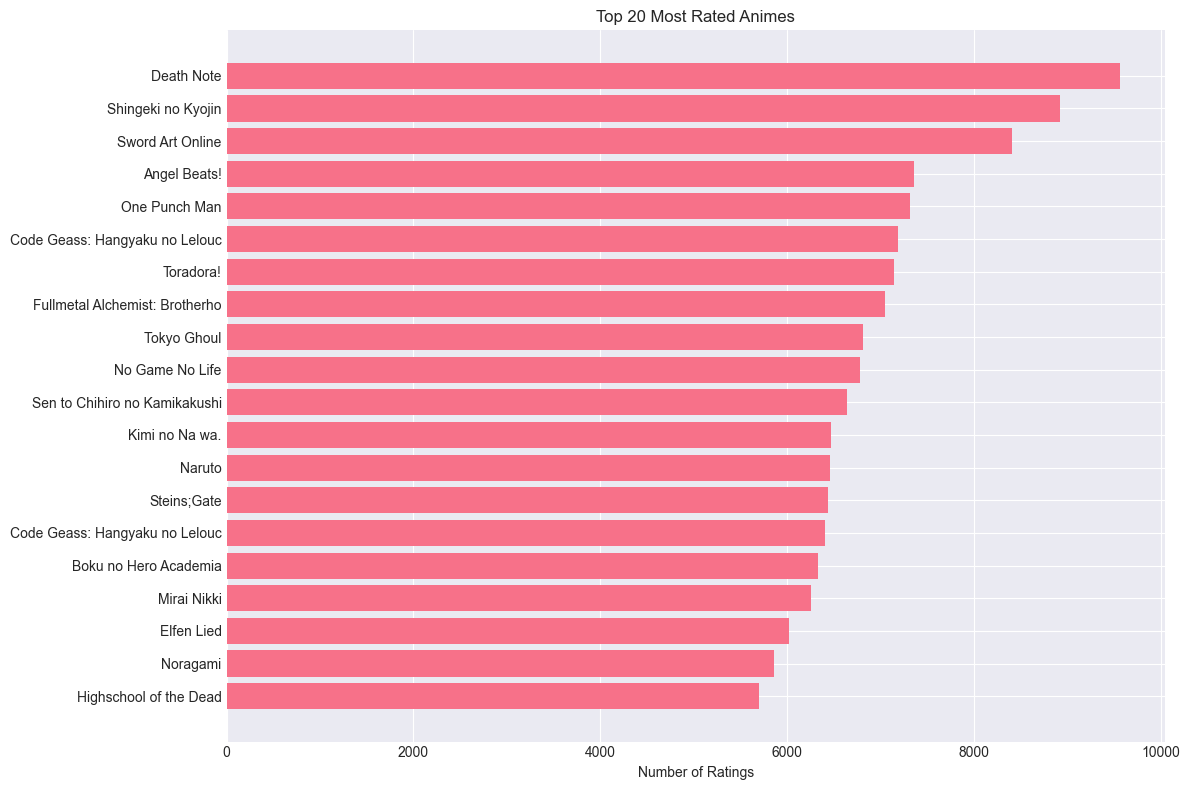

In [51]:
# 4.4. Top 20 most rated animes
top_20 = sorted(anime_counts.items(), key=lambda x: x[1], reverse=True)[:20]

anime_names = []
counts = []
for anime_id, count in top_20:
    name = anime_dict.get(anime_id, {}).get('name', f'ID: {anime_id}')
    anime_names.append(name[:30])  # Truncate long names
    counts.append(count)

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(anime_names)), counts)
ax.set_yticks(range(len(anime_names)))
ax.set_yticklabels(anime_names)
ax.set_xlabel('Number of Ratings')
ax.set_title('Top 20 Most Rated Animes')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [52]:
# 4.5. Sparsity calculation
num_users = len(user_counts)
num_animes = len(anime_counts)
num_ratings = len(ratings_data)
total_possible = num_users * num_animes
sparsity = 1 - (num_ratings / total_possible)

print("="*60)
print("MATRIX SPARSITY")
print("="*60)
print(f"Users: {num_users:,}")
print(f"Animes: {num_animes:,}")
print(f"Possible ratings: {total_possible:,}")
print(f"Actual ratings: {num_ratings:,}")
print(f"Sparsity: {sparsity:.4%}")
print("="*60)

MATRIX SPARSITY
Users: 16,131
Animes: 14,636
Possible ratings: 236,093,316
Actual ratings: 3,000,003
Sparsity: 98.7293%


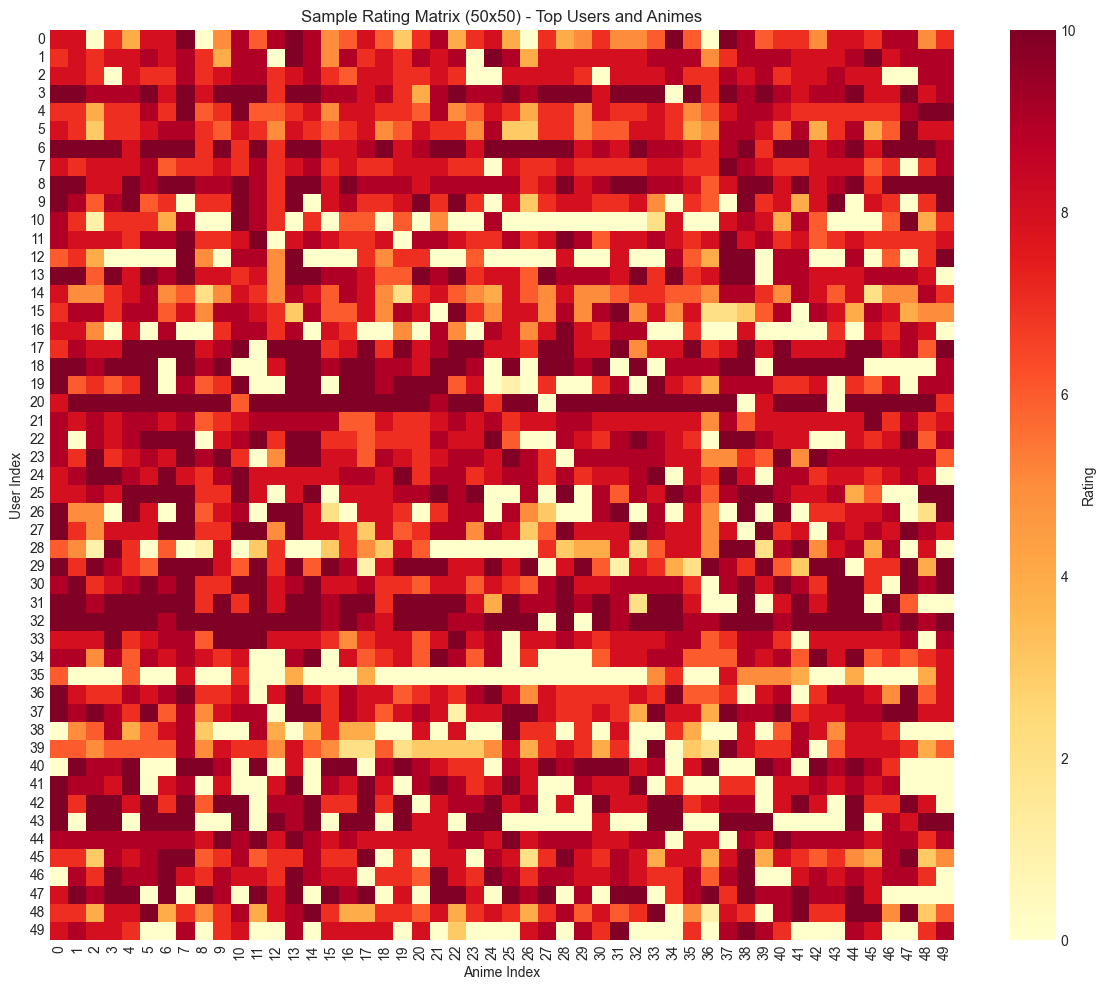

In [53]:
# 4.6. Sample heatmap (50 users x 50 animes)
# Select top 50 active users and popular animes
top_users = sorted(user_counts.items(), key=lambda x: x[1], reverse=True)[:50]
top_users = [u[0] for u in top_users]

top_animes_for_heatmap = sorted(anime_counts.items(), key=lambda x: x[1], reverse=True)[:50]
top_animes_for_heatmap = [a[0] for a in top_animes_for_heatmap]

# Build matrix
matrix = np.zeros((50, 50))
for r in ratings_data:
    if r['user_id'] in top_users and r['anime_id'] in top_animes_for_heatmap:
        i = top_users.index(r['user_id'])
        j = top_animes_for_heatmap.index(r['anime_id'])
        matrix[i, j] = r['rating']

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(matrix, cmap='YlOrRd', cbar_kws={'label': 'Rating'}, ax=ax)
ax.set_xlabel('Anime Index')
ax.set_ylabel('User Index')
ax.set_title('Sample Rating Matrix (50x50) - Top Users and Animes')
plt.tight_layout()
plt.show()

## 5. Chunking Dữ Liệu - Stratified User Split

**Method:** Chia ratings của MỖI user theo tỷ lệ train/test

**Parameters:**
- test_ratio: 0.2 (80% train, 20% test)
- min_ratings: 5 (users với <5 ratings → all vào train)
- seed: 42

**Benefits:**
- Tất cả users trong test cũng có trong train (no cold start)
- Preserve user rating patterns
- Fair evaluation


In [54]:
def split_by_user(ratings_data, test_ratio=0.2, min_ratings=5, seed=42):
    """Stratified user-based split - theo train.py:70-118"""
    random.seed(seed)
    np.random.seed(seed)
    
    print(f"Splitting data (Stratified by User, {int((1-test_ratio)*100)}/{int(test_ratio*100)})...")
    
    # Group by user
    user_ratings = defaultdict(list)
    for rating in ratings_data:
        user_ratings[rating['user_id']].append(rating)
    
    train_data = []
    test_data = []
    
    for user_id, ratings in user_ratings.items():
        # Shuffle user's ratings
        random.shuffle(ratings)
        
        # If user has enough ratings, split them
        if len(ratings) >= min_ratings:
            split_point = int(len(ratings) * (1 - test_ratio))
            train_data.extend(ratings[:split_point])
            test_data.extend(ratings[split_point:])
        else:
            # Too few ratings, put all in train
            train_data.extend(ratings)
    
    print(f"  Train: {len(train_data):,} ratings ({len(set([r['user_id'] for r in train_data])):,} users)")
    print(f"  Test: {len(test_data):,} ratings ({len(set([r['user_id'] for r in test_data])):,} users)")
    
    return train_data, test_data

# Split data
train_data, test_data = split_by_user(ratings_data, test_ratio=0.2, min_ratings=5, seed=42)
print("\nData split complete!")

Splitting data (Stratified by User, 80/20)...
  Train: 2,394,261 ratings (16,131 users)
  Test: 605,742 ratings (15,274 users)

Data split complete!


## 6. Train 4 Models

Chúng ta sẽ train 4 models với hyperparameters chính xác từ production:
1. **User-Based CF**: k_neighbors=50, similarity='cosine'
2. **Item-Based CF**: k_similar=30, similarity='adjusted_cosine', min_ratings=100
3. **Neural CF**: embedding_dim=64, mlp_layers=[128,64,32], epochs=30
4. **Hybrid**: Weighted combination với optimized weights


### 6.1. User-Based Collaborative Filtering

In [55]:
print("="*80)
print("TRAINING: USER-BASED COLLABORATIVE FILTERING")
print("="*80)

user_model = UserBasedCF(
    k_neighbors=50,
    similarity='cosine',
    min_overlap=3
)

print("Training User-Based CF...")
user_model.fit(train_data)

print("User-Based CF trained successfully!")

TRAINING: USER-BASED COLLABORATIVE FILTERING
Training User-Based CF...
Training User-Based CF (k=50, similarity=cosine)...
  Users: 16,131
  Animes: 14,346
  Ratings: 2,394,261
  Matrix shape: (16131, 14346)
  Sparsity: 98.97%
  Computing user similarity matrix...
  Training complete!
User-Based CF trained successfully!


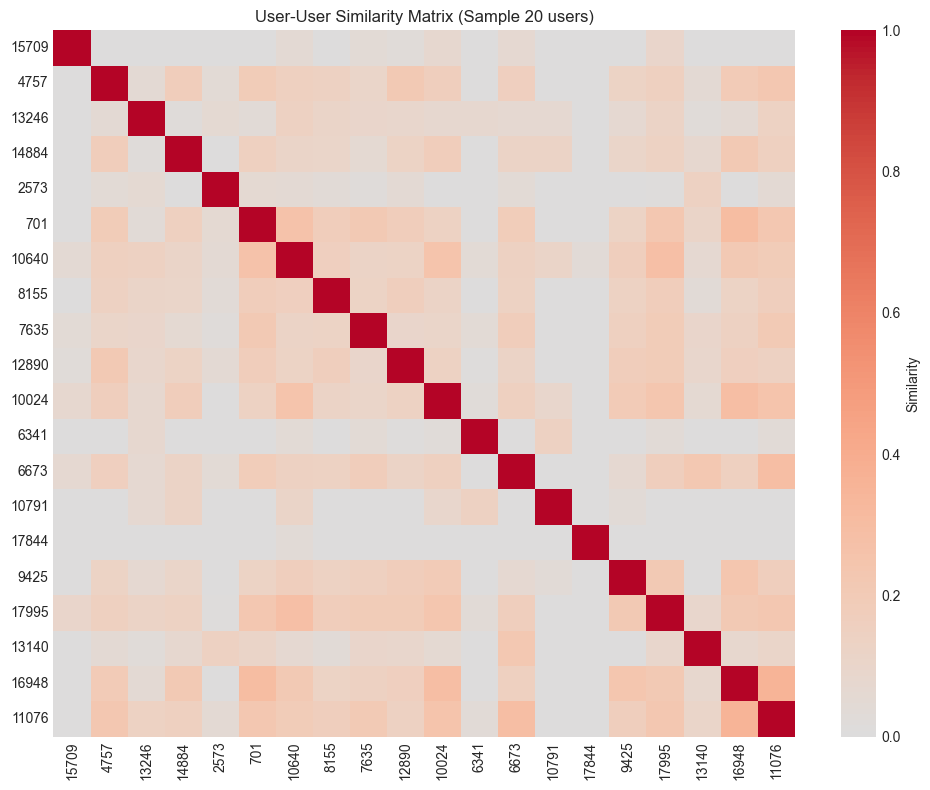

Mean similarity: 0.1380
Max similarity: 1.0000


In [56]:
# Visualize sample user similarity matrix
# Get 20 random users
sample_users = random.sample(list(user_model.user_id_map.keys()), min(20, len(user_model.user_id_map)))
user_indices = [user_model.user_id_map[u] for u in sample_users]

# Extract similarity submatrix
sim_matrix = user_model.user_similarity.toarray()
sample_sim = sim_matrix[np.ix_(user_indices, user_indices)]

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(sample_sim, cmap='coolwarm', center=0, 
            xticklabels=sample_users, yticklabels=sample_users,
            cbar_kws={'label': 'Similarity'}, ax=ax)
ax.set_title('User-User Similarity Matrix (Sample 20 users)')
plt.tight_layout()
plt.show()

print(f"Mean similarity: {np.mean(sample_sim):.4f}")
print(f"Max similarity: {np.max(sample_sim):.4f}")

### 6.2. Item-Based Collaborative Filtering

In [57]:
print("="*80)
print("TRAINING: ITEM-BASED COLLABORATIVE FILTERING")
print("="*80)

item_model = ItemBasedCF(
    k_similar=30,
    similarity='adjusted_cosine',
    min_ratings=100
)

print("Training Item-Based CF...")
item_model.fit(train_data)

print("Item-Based CF trained successfully!")

TRAINING: ITEM-BASED COLLABORATIVE FILTERING
Training Item-Based CF...
Training Item-Based CF (k=30, similarity=adjusted_cosine)...
  Users: 16,131
  Animes: 14,346
  Ratings: 2,394,261
  Matrix shape: (16131, 14346)
  Sparsity: 98.97%
  Items with >= 100 ratings: 3,597
  Computing user means...
  Computing item similarity matrix...
  Training complete!
Item-Based CF trained successfully!


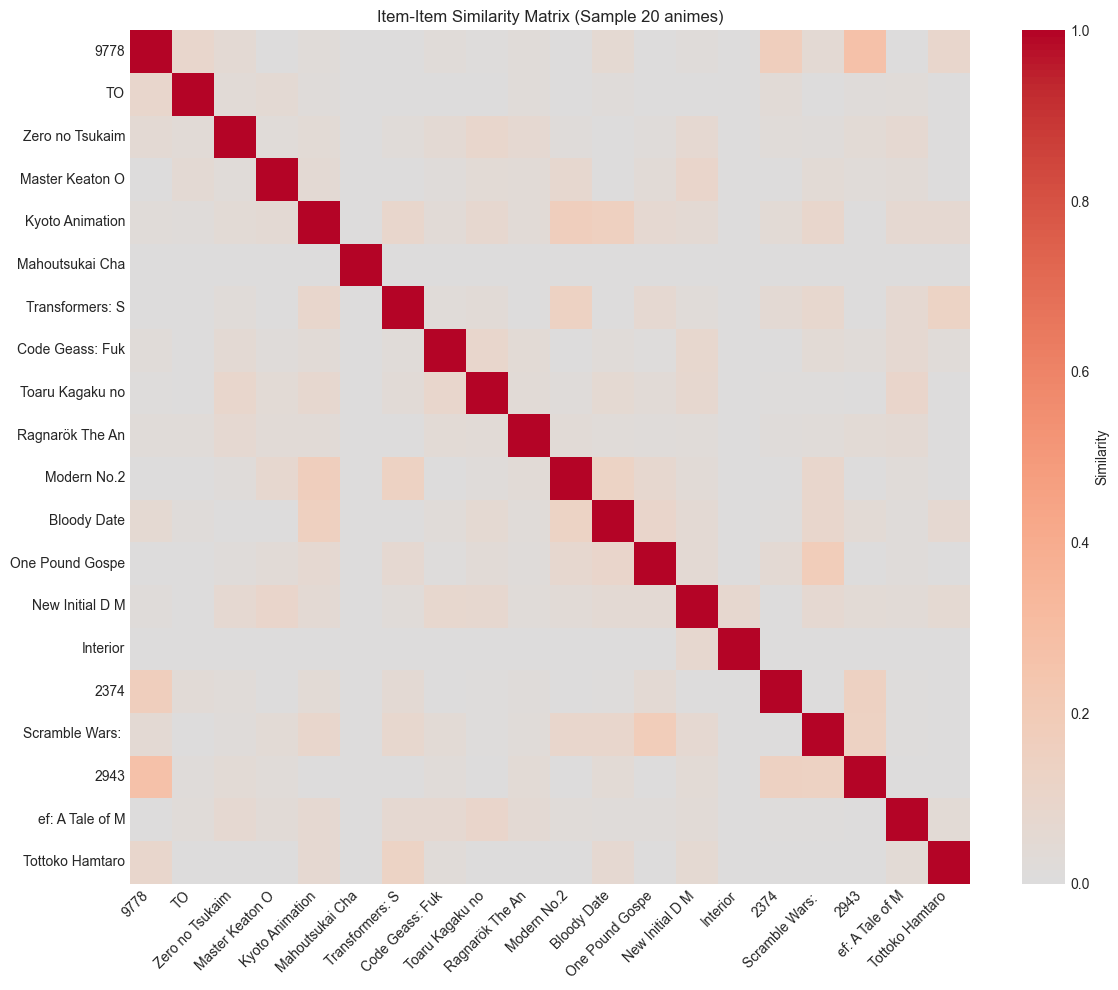

Mean similarity: 0.0821


In [58]:
# Visualize sample item similarity matrix
sample_items = random.sample(list(item_model.anime_id_map.keys()), min(20, len(item_model.anime_id_map)))
item_indices = [item_model.anime_id_map[i] for i in sample_items]

sim_matrix = item_model.item_similarity.toarray()
sample_sim = sim_matrix[np.ix_(item_indices, item_indices)]

# Get anime names for labels
labels = [anime_dict.get(anime_id, {}).get('name', str(anime_id))[:15] for anime_id in sample_items]

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(sample_sim, cmap='coolwarm', center=0,
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Similarity'}, ax=ax)
ax.set_title('Item-Item Similarity Matrix (Sample 20 animes)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"Mean similarity: {np.mean(sample_sim):.4f}")

In [59]:
# Demo: Find similar animes
# Pick a popular anime
demo_anime_id = sorted(anime_counts.items(), key=lambda x: x[1], reverse=True)[0][0]
demo_anime_name = anime_dict.get(demo_anime_id, {}).get('name', 'Unknown')

print(f"Finding animes similar to: {demo_anime_name}")
print("="*60)

similar = item_model.get_similar_animes(demo_anime_id, n=10)
for i, (anime_id, sim_score) in enumerate(similar, 1):
    name = anime_dict.get(anime_id, {}).get('name', f'ID: {anime_id}')
    print(f"{i:2d}. {name[:50]:<50} | Similarity: {sim_score:.4f}")

Finding animes similar to: Death Note
 1. Shingeki no Kyojin                                 | Similarity: 0.5580
 2. Code Geass: Hangyaku no Lelouch                    | Similarity: 0.5383
 3. Code Geass: Hangyaku no Lelouch R2                 | Similarity: 0.5238
 4. Fullmetal Alchemist: Brotherhood                   | Similarity: 0.5203
 5. Steins;Gate                                        | Similarity: 0.5056
 6. Sword Art Online                                   | Similarity: 0.5043
 7. Naruto                                             | Similarity: 0.4964
 8. Tokyo Ghoul                                        | Similarity: 0.4947
 9. One Punch Man                                      | Similarity: 0.4937
10. Angel Beats!                                       | Similarity: 0.4864


### 6.3. Neural Collaborative Filtering (NCF)

NCF requires continuous user/item IDs starting from 0. We'll create ID mappings.


In [60]:
print("="*80)
print("TRAINING: NEURAL COLLABORATIVE FILTERING")
print("="*80)

# Create ID mappings
print("Preparing NCF training data...")

all_data = train_data + test_data
user_ids = sorted(set(r['user_id'] for r in all_data))
item_ids = sorted(set(r['anime_id'] for r in all_data))

user_id_map = {uid: idx for idx, uid in enumerate(user_ids)}
item_id_map = {iid: idx for idx, iid in enumerate(item_ids)}

# Map train data
mapped_train = []
for r in train_data:
    if r['user_id'] in user_id_map and r['anime_id'] in item_id_map:
        mapped_train.append({
            'user_id': user_id_map[r['user_id']],
            'anime_id': item_id_map[r['anime_id']],
            'rating': r['rating']
        })

# Map test data
mapped_test = []
for r in test_data:
    if r['user_id'] in user_id_map and r['anime_id'] in item_id_map:
        mapped_test.append({
            'user_id': user_id_map[r['user_id']],
            'anime_id': item_id_map[r['anime_id']],
            'rating': r['rating']
        })

print(f"  Mapped {len(mapped_train):,} train ratings")
print(f"  Mapped {len(mapped_test):,} test ratings")
print(f"  Users: {len(user_id_map):,}")
print(f"  Items: {len(item_id_map):,}")

TRAINING: NEURAL COLLABORATIVE FILTERING
Preparing NCF training data...
  Mapped 2,394,261 train ratings
  Mapped 605,742 test ratings
  Users: 16,131
  Items: 14,636


In [61]:
# Initialize NCF model
ncf_model = NeuralCF(
    num_users=len(user_id_map),
    num_items=len(item_id_map),
    embedding_dim=64,
    mlp_layers=[128, 64, 32],
    dropout=0.2
)

print(f"Model architecture:")
print(f"  GMF embedding: {64}")
print(f"  MLP layers: {[128, 64, 32]}")
print(f"  Total params: {sum(p.numel() for p in ncf_model.parameters()):,}")

Model architecture:
  GMF embedding: 64
  MLP layers: [128, 64, 32]
  Total params: 3,948,801


In [62]:
# Train NCF
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training on device: {device}\n")

ncf_model.fit(
    train_data=mapped_train,
    val_data=mapped_test,
    epochs=30,
    batch_size=256,
    lr=0.001,
    early_stopping=5,
    device=device
)

# Save ID mappings
ncf_model.user_id_map = user_id_map
ncf_model.item_id_map = item_id_map
ncf_model.reverse_user_map = {v: k for k, v in user_id_map.items()}
ncf_model.reverse_item_map = {v: k for k, v in item_id_map.items()}

print("\nNeural CF trained successfully!")

Training on device: cpu



Epoch 1/30: 100%|██████████| 9353/9353 [03:35<00:00, 43.33it/s, loss=1.67]


Epoch 1: Train Loss = 3.2041, Val Loss = 1.4492


Epoch 2/30: 100%|██████████| 9353/9353 [03:33<00:00, 43.86it/s, loss=0.922]


Epoch 2: Train Loss = 1.3736, Val Loss = 1.3675


Epoch 3/30: 100%|██████████| 9353/9353 [03:35<00:00, 43.45it/s, loss=1.2]  


Epoch 3: Train Loss = 1.0379, Val Loss = 1.3907


Epoch 4/30: 100%|██████████| 9353/9353 [03:37<00:00, 43.07it/s, loss=0.725]


Epoch 4: Train Loss = 0.8740, Val Loss = 1.4277


Epoch 5/30: 100%|██████████| 9353/9353 [03:36<00:00, 43.13it/s, loss=0.953]


Epoch 5: Train Loss = 0.7834, Val Loss = 1.4698


Epoch 6/30: 100%|██████████| 9353/9353 [03:50<00:00, 40.51it/s, loss=0.743]


Epoch 6: Train Loss = 0.7244, Val Loss = 1.5011


Epoch 7/30: 100%|██████████| 9353/9353 [03:30<00:00, 44.43it/s, loss=0.748]


Epoch 7: Train Loss = 0.6808, Val Loss = 1.5325
Early stopping at epoch 7

Neural CF trained successfully!


### 6.4. Hybrid Model - Weighted Combination

Optimize weights using grid search trên validation set.


In [63]:
def optimize_hybrid_weights(user_model, item_model, train_data, test_data):
    print("="*60)
    print("OPTIMIZING HYBRID WEIGHTS")
    print("="*60)
    
    # Sample validation set
    val_size = min(1000, len(test_data))
    val_data = random.sample(test_data, val_size)
    
    best_alpha = 0.5
    best_rmse = float('inf')
    
    alphas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    results = []
    
    print(f"\nTrying {len(alphas)} different weights on {val_size} validation samples...\n")
    
    for alpha in alphas:
        hybrid = HybridWeightedCF(user_model, item_model,
                                  user_weight=alpha, item_weight=1-alpha)
        
        # Compute RMSE on validation
        errors = []
        for rating in val_data:
            pred = hybrid.predict(rating['user_id'], rating['anime_id'])
            if pred > 0:
                errors.append((rating['rating'] - pred) ** 2)
        
        if len(errors) > 0:
            rmse = np.sqrt(np.mean(errors))
            results.append((alpha, rmse, len(errors)))
            print(f"  α={alpha:.1f}: RMSE={rmse:.4f} ({len(errors)} predictions)")
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_alpha = alpha
    
    print(f"\nBest weight: α={best_alpha:.1f} (RMSE={best_rmse:.4f})")
    
    return best_alpha, results

# Optimize
best_alpha, optimization_results = optimize_hybrid_weights(user_model, item_model, train_data, test_data)

OPTIMIZING HYBRID WEIGHTS

Trying 11 different weights on 1000 validation samples...

Hybrid Model initialized:
  User-Based weight: 0.00
  Item-Based weight: 1.00
  α=0.0: RMSE=1.2756 (1000 predictions)
Hybrid Model initialized:
  User-Based weight: 0.10
  Item-Based weight: 0.90
  α=0.1: RMSE=1.2586 (1000 predictions)
Hybrid Model initialized:
  User-Based weight: 0.20
  Item-Based weight: 0.80
  α=0.2: RMSE=1.2500 (1000 predictions)
Hybrid Model initialized:
  User-Based weight: 0.30
  Item-Based weight: 0.70
  α=0.3: RMSE=1.2500 (1000 predictions)
Hybrid Model initialized:
  User-Based weight: 0.40
  Item-Based weight: 0.60
  α=0.4: RMSE=1.2586 (1000 predictions)
Hybrid Model initialized:
  User-Based weight: 0.50
  Item-Based weight: 0.50
  α=0.5: RMSE=1.2756 (1000 predictions)
Hybrid Model initialized:
  User-Based weight: 0.60
  Item-Based weight: 0.40
  α=0.6: RMSE=1.3007 (1000 predictions)
Hybrid Model initialized:
  User-Based weight: 0.70
  Item-Based weight: 0.30
  α=0.7: R

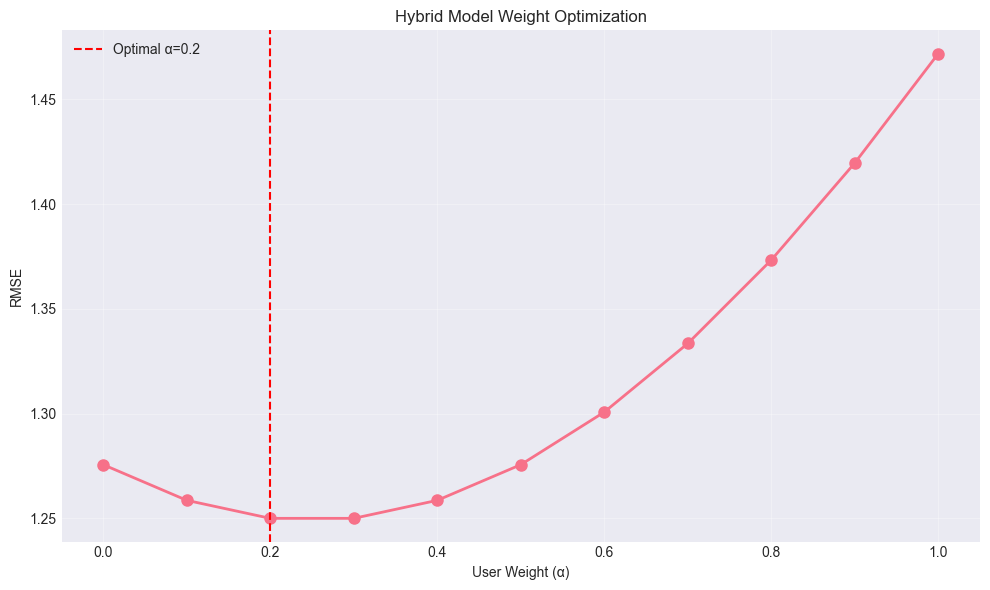

In [64]:
# Plot optimization results
alphas = [r[0] for r in optimization_results]
rmses = [r[1] for r in optimization_results]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(alphas, rmses, 'o-', linewidth=2, markersize=8)
ax.axvline(best_alpha, color='red', linestyle='--', label=f'Optimal α={best_alpha:.1f}')
ax.set_xlabel('User Weight (α)')
ax.set_ylabel('RMSE')
ax.set_title('Hybrid Model Weight Optimization')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

In [65]:
# Create final hybrid model
print("="*80)
print("CREATING HYBRID MODEL")
print("="*80)

hybrid_model = HybridWeightedCF(
    user_model, item_model,
    user_weight=best_alpha,
    item_weight=1-best_alpha
)

print(f"Hybrid weights:")
print(f"  User-Based: {best_alpha:.2f}")
print(f"  Item-Based: {1-best_alpha:.2f}")
print("\nHybrid model created!")

CREATING HYBRID MODEL
Hybrid Model initialized:
  User-Based weight: 0.20
  Item-Based weight: 0.80
Hybrid weights:
  User-Based: 0.20
  Item-Based: 0.80

Hybrid model created!


## 7. Đánh Giá 4 Models

**7 Metrics:**
1. **RMSE** - Root Mean Squared Error (lower is better)
2. **MAE** - Mean Absolute Error (lower is better)
3. **Precision@10** - Recommendation precision (higher is better)
4. **Recall@10** - Recommendation recall (higher is better)
5. **Coverage** - Catalog coverage (higher is better)
6. **Diversity** - Recommendation diversity (higher is better)
7. **Novelty** - Recommendation novelty (higher is better)


In [66]:
# Evaluate all 4 models
print("\n" + "="*80)
print("EVALUATING ALL MODELS")
print("="*80)

user_metrics = evaluate_model(user_model, train_data, test_data, k=10)
item_metrics = evaluate_model(item_model, train_data, test_data, k=10)
hybrid_metrics = evaluate_model(hybrid_model, train_data, test_data, k=10)
ncf_metrics = evaluate_model(ncf_model, train_data, test_data, k=10)

print("\nAll models evaluated!")


EVALUATING ALL MODELS

EVALUATING MODEL

1. Computing RMSE & MAE...
  RMSE: 1.437700/10000
  MAE: 1.0992
  Coverage: 99.98% (9998/10000)

2. Computing Precision@10 & Recall@10...
  Precision@10: 0.3340
  Recall@10: 0.1384
  Evaluated users: 50

3. Computing coverage...
  Coverage: 1.61% (231/14346 items)

4. Computing diversity...
  Diversity: 1.0000

5. Computing novelty...
  Novelty: 9.3592

EVALUATION COMPLETE

EVALUATING MODEL

1. Computing RMSE & MAE...
  RMSE: 1.281200/10000
  MAE: 0.9443
  Coverage: 99.92% (9992/10000)

2. Computing Precision@10 & Recall@10...
  Precision@10: 0.0320
  Recall@10: 0.0351
  Evaluated users: 50

3. Computing coverage...
  Coverage: 3.53% (506/14346 items)

4. Computing diversity...
  Diversity: 1.0000

5. Computing novelty...
  Novelty: 12.6672

EVALUATION COMPLETE

EVALUATING MODEL

1. Computing RMSE & MAE...
  RMSE: 1.228800/10000
  MAE: 0.9225
  Coverage: 99.96% (9996/10000)

2. Computing Precision@10 & Recall@10...
  Precision@10: 0.0700
  Reca

In [67]:
# Comparison using built-in compare function
compare_models({
    'User-Based CF': user_metrics,
    'Item-Based CF': item_metrics,
    'Hybrid': hybrid_metrics,
    'Neural CF': ncf_metrics
})


MODEL COMPARISON

Metric                   User-Based CF       Item-Based CF       Hybrid              Neural CF           
--------------------------------------------------------------------------------
coverage                 0.0161              0.0353              0.0342              0.0380              
diversity                1.0000              1.0000              1.0000              1.0000              
evaluated_users          50                  50                  50                  50                  
mae                      1.0992              0.9443              0.9225              0.9038              
novelty                  9.3592              12.6672             12.4104             12.2823             
precision_at_k           0.3340              0.0320              0.0700              0.0220              
prediction_coverage      0.9998              0.9992              0.9996              1.0000              
recall_at_k              0.1384              0.0351 

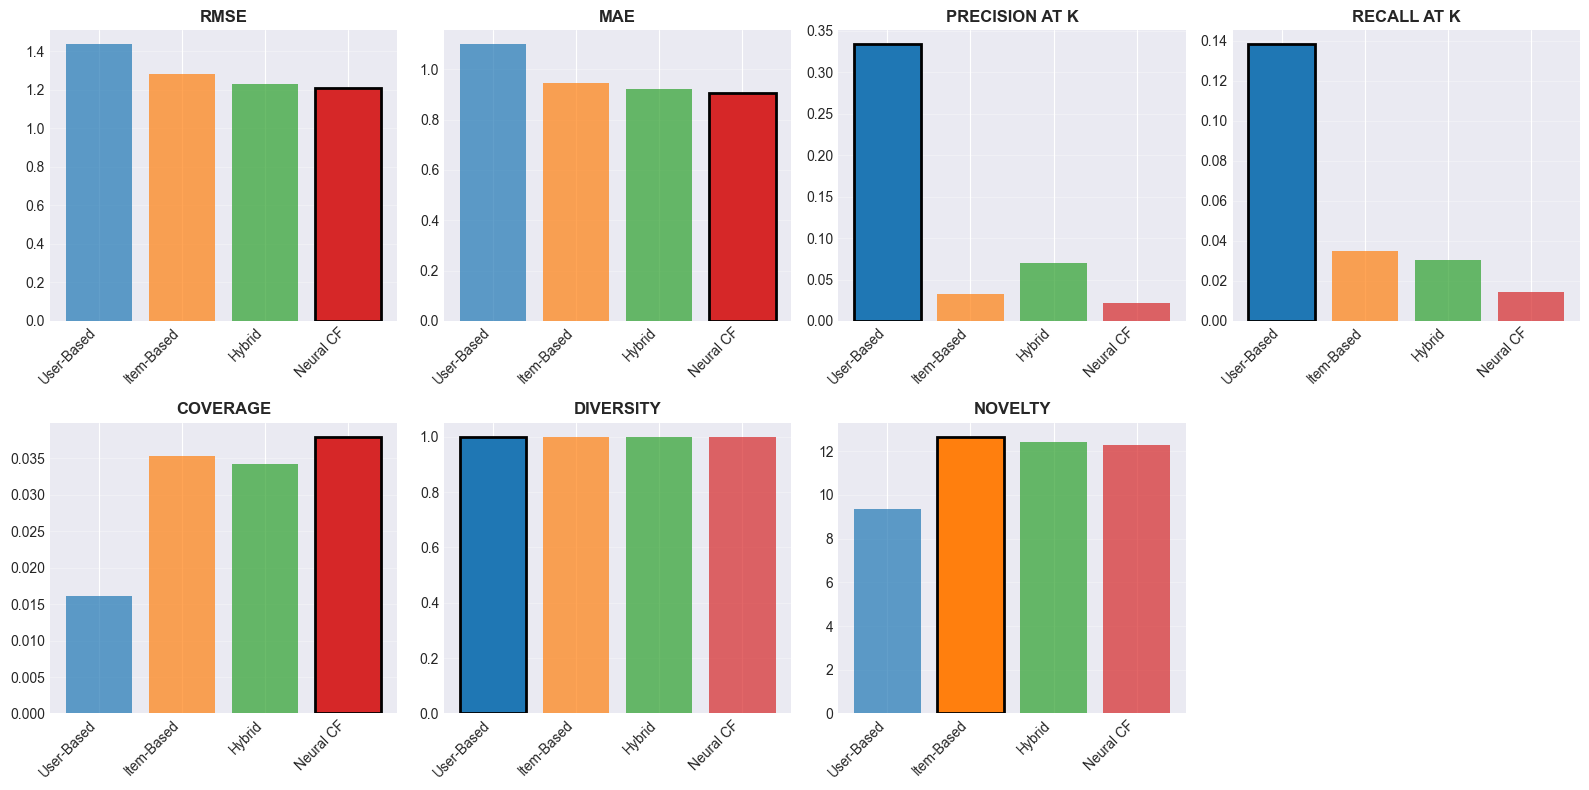

In [68]:
# Visualization: Comparison charts
metrics_to_plot = ['rmse', 'mae', 'precision_at_k', 'recall_at_k', 'coverage', 'diversity', 'novelty']
model_names = ['User-Based', 'Item-Based', 'Hybrid', 'Neural CF']
all_metrics = [user_metrics, item_metrics, hybrid_metrics, ncf_metrics]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    values = [m.get(metric, 0) for m in all_metrics]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    bars = ax.bar(model_names, values, color=colors, alpha=0.7)
    
    # Highlight best
    is_lower_better = metric in ['rmse', 'mae']
    if is_lower_better:
        best_idx = values.index(min(values))
    else:
        best_idx = values.index(max(values))
    bars[best_idx].set_alpha(1.0)
    bars[best_idx].set_edgecolor('black')
    bars[best_idx].set_linewidth(2)
    
    ax.set_title(metric.upper().replace('_', ' '), fontweight='bold')
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

# Remove extra subplot
axes[7].remove()

plt.tight_layout()
plt.show()

## 8. Demo Recommendations

Chọn một user và xem recommendations từ cả 4 models.


In [69]:
# Select demo user (user with >= 20 ratings)
demo_user = None
for user_id, count in user_counts.items():
    if count >= 20:
        demo_user = user_id
        break

if demo_user is None:
    demo_user = list(user_counts.keys())[0]

print(f"Demo User ID: {demo_user}")
print(f"Number of ratings: {user_counts[demo_user]}")
print("="*80)

Demo User ID: 0
Number of ratings: 36


In [70]:
# Display user's rating history (top 10)
user_ratings_history = [r for r in ratings_data if r['user_id'] == demo_user]
user_ratings_history.sort(key=lambda x: x['rating'], reverse=True)

print("USER'S TOP 10 RATINGS:")
print("="*80)
for i, r in enumerate(user_ratings_history[:10], 1):
    anime_name = anime_dict.get(r['anime_id'], {}).get('name', f"ID: {r['anime_id']}")
    genres = anime_dict.get(r['anime_id'], {}).get('genres', 'N/A')
    print(f"{i:2d}. [{r['rating']:2d}/10] {anime_name[:50]:<50} | {genres[:30]}")

print("="*80)

USER'S TOP 10 RATINGS:
 1. [10/10] Hotaru no Haka                                     | Drama, Historical
 2. [10/10] Ghost Hunt                                         | Mystery, Comedy, Horror, Super
 3. [10/10] Tonari no Yamada-kun                               | Slice of Life, Comedy
 4. [10/10] Toki wo Kakeru Shoujo                              | Adventure, Drama, Romance, Sci
 5. [10/10] Boruto: Naruto Next Generations                    | Action, Adventure, Super Power
 6. [ 9/10] Fullmetal Alchemist: The Conqueror of Shamballa    | Military, Comedy, Historical, 
 7. [ 9/10] Igano Kabamaru                                     | Action, Adventure, Comedy, Rom
 8. [ 9/10] Fullmetal Alchemist                                | Action, Adventure, Comedy, Dra
 9. [ 9/10] Fate/stay night                                    | Action, Supernatural, Magic, R
10. [ 9/10] Jungle no Ouja Taa-chan                            | Action, Comedy, Parody


In [71]:
# Get recommendations from all 4 models
print("\nGETTING RECOMMENDATIONS FROM ALL MODELS...\n")

user_recs = user_model.recommend(demo_user, n=10, exclude_rated=True)
item_recs = item_model.recommend(demo_user, n=10, exclude_rated=True)
hybrid_recs = hybrid_model.recommend(demo_user, n=10, exclude_rated=True)
ncf_recs = ncf_model.recommend(demo_user, n=10, exclude_rated=True)

print("Recommendations generated!")


GETTING RECOMMENDATIONS FROM ALL MODELS...

Recommendations generated!


In [72]:
# Display User-Based CF recommendations
print("="*80)
print("RECOMMENDATIONS: USER-BASED CF")
print("="*80)
print(f"{'Rank':<6}{'Anime ID':<12}{'Name':<50}{'Pred.Rating':<12}{'Genres':<30}")
print("-"*110)

for i, (anime_id, pred_rating) in enumerate(user_recs, 1):
    name = anime_dict.get(anime_id, {}).get('name', f'ID: {anime_id}')
    genres = anime_dict.get(anime_id, {}).get('genres', 'N/A')
    print(f"{i:<6}{anime_id:<12}{name[:48]:<50}{pred_rating:<12.2f}{genres[:28]:<30}")

RECOMMENDATIONS: USER-BASED CF
Rank  Anime ID    Name                                              Pred.Rating Genres                        
--------------------------------------------------------------------------------------------------------------
1     523         Tonari no Totoro                                  3.07        Adventure, Comedy, Supernatu  
2     1535        Death Note                                        2.85        Mystery, Police, Psychologic  
3     513         Tenkuu no Shiro Laputa                            2.16        Adventure, Fantasy, Romance,  
4     317         Final Fantasy VII: Advent Children                1.85        Action, Super Power, Fantasy  
5     512         Majo no Takkyuubin                                1.80        Adventure, Comedy, Drama, Ma  
6     597         Neko no Ongaeshi                                  1.79        Adventure, Drama, Fantasy     
7     1575        Code Geass: Hangyaku no Lelouch                   1.65        A

In [73]:
# Display Item-Based CF recommendations
print("="*80)
print("RECOMMENDATIONS: ITEM-BASED CF")
print("="*80)
print(f"{'Rank':<6}{'Anime ID':<12}{'Name':<50}{'Pred.Rating':<12}{'Genres':<30}")
print("-"*110)

for i, (anime_id, pred_rating) in enumerate(item_recs, 1):
    name = anime_dict.get(anime_id, {}).get('name', f'ID: {anime_id}')
    genres = anime_dict.get(anime_id, {}).get('genres', 'N/A')
    print(f"{i:<6}{anime_id:<12}{name[:48]:<50}{pred_rating:<12.2f}{genres[:28]:<30}")

RECOMMENDATIONS: ITEM-BASED CF
Rank  Anime ID    Name                                              Pred.Rating Genres                        
--------------------------------------------------------------------------------------------------------------
1     16664       Kaguya-hime no Monogatari                         8.17        Fantasy, Historical           
2     39533       Given                                             8.16        Drama, Music, Romance, Shoun  
3     40456       Kimetsu no Yaiba Movie: Mugen Ressha-hen          8.15        Action, Historical, Demons,   
4     34537       Yoru wa Mijikashi Arukeyo Otome                   8.13        Comedy, Romance               
5     21557       Omoide no Marnie                                  8.12        Mystery, Psychological, Dram  
6     15227       Kono Sekai no Katasumi ni                         8.11        Historical, Drama, Seinen     
7     37779       Yakusoku no Neverland                             8.11        S

In [74]:
# Display Hybrid recommendations
print("="*80)
print("RECOMMENDATIONS: HYBRID MODEL")
print("="*80)
print(f"{'Rank':<6}{'Anime ID':<12}{'Name':<50}{'Pred.Rating':<12}{'Genres':<30}")
print("-"*110)

for i, (anime_id, pred_rating) in enumerate(hybrid_recs, 1):
    name = anime_dict.get(anime_id, {}).get('name', f'ID: {anime_id}')
    genres = anime_dict.get(anime_id, {}).get('genres', 'N/A')
    print(f"{i:<6}{anime_id:<12}{name[:48]:<50}{pred_rating:<12.2f}{genres[:28]:<30}")

RECOMMENDATIONS: HYBRID MODEL
Rank  Anime ID    Name                                              Pred.Rating Genres                        
--------------------------------------------------------------------------------------------------------------
1     16664       Kaguya-hime no Monogatari                         6.53        Fantasy, Historical           
2     39533       Given                                             6.53        Drama, Music, Romance, Shoun  
3     40456       Kimetsu no Yaiba Movie: Mugen Ressha-hen          6.52        Action, Historical, Demons,   
4     34537       Yoru wa Mijikashi Arukeyo Otome                   6.51        Comedy, Romance               
5     21557       Omoide no Marnie                                  6.50        Mystery, Psychological, Dram  
6     15227       Kono Sekai no Katasumi ni                         6.49        Historical, Drama, Seinen     
7     37779       Yakusoku no Neverland                             6.49        Sc

In [75]:
# Display Neural CF recommendations
print("="*80)
print("RECOMMENDATIONS: NEURAL CF")
print("="*80)
print(f"{'Rank':<6}{'Anime ID':<12}{'Name':<50}{'Pred.Rating':<12}{'Genres':<30}")
print("-"*110)

for i, (anime_id, pred_rating) in enumerate(ncf_recs, 1):
    name = anime_dict.get(anime_id, {}).get('name', f'ID: {anime_id}')
    genres = anime_dict.get(anime_id, {}).get('genres', 'N/A')
    print(f"{i:<6}{anime_id:<12}{name[:48]:<50}{pred_rating:<12.2f}{genres[:28]:<30}")

RECOMMENDATIONS: NEURAL CF
Rank  Anime ID    Name                                              Pred.Rating Genres                        
--------------------------------------------------------------------------------------------------------------
1     457         Mushishi                                          10.00       Adventure, Slice of Life, My  
2     962         Aria the Natural                                  10.00       Sci-Fi, Slice of Life, Fanta  
3     1453        Maison Ikkoku                                     10.00       Slice of Life, Comedy, Drama  
4     2459        Maison Ikkoku: Bangai-hen - Ikkokujima Nanpa Shi  10.00       Comedy, Drama, Romance, Sein  
5     3090        Aa! Megami-sama!: Tatakau Tsubasa                 10.00       Comedy, Magic, Romance, Sein  
6     3297        Aria the Origination                              10.00       Sci-Fi, Slice of Life, Fanta  
7     4772        Aria the Origination: Sono Choppiri Himitsu no B  10.00       Slice

In [76]:
# Analyze overlap between models
all_recs = {
    'User-Based': set([anime_id for anime_id, _ in user_recs]),
    'Item-Based': set([anime_id for anime_id, _ in item_recs]),
    'Hybrid': set([anime_id for anime_id, _ in hybrid_recs]),
    'Neural CF': set([anime_id for anime_id, _ in ncf_recs])
}

print("="*80)
print("RECOMMENDATION OVERLAP ANALYSIS")
print("="*80)

# Pairwise overlap
from itertools import combinations
for (name1, recs1), (name2, recs2) in combinations(all_recs.items(), 2):
    overlap = len(recs1 & recs2)
    print(f"{name1} ∩ {name2}: {overlap}/10 common recommendations")

# Common across all models
common_all = set.intersection(*all_recs.values())
print(f"\nCommon across all 4 models: {len(common_all)}/10")
if common_all:
    print("  Anime IDs:", common_all)

# Unique recommendations
print("\nUnique recommendations (appears in only 1 model):")
for name, recs in all_recs.items():
    others = set.union(*[r for n, r in all_recs.items() if n != name])
    unique = recs - others
    if unique:
        print(f"  {name}: {len(unique)} unique - {list(unique)[:3]}")

RECOMMENDATION OVERLAP ANALYSIS
User-Based ∩ Item-Based: 0/10 common recommendations
User-Based ∩ Hybrid: 0/10 common recommendations
User-Based ∩ Neural CF: 0/10 common recommendations
Item-Based ∩ Hybrid: 10/10 common recommendations
Item-Based ∩ Neural CF: 0/10 common recommendations
Hybrid ∩ Neural CF: 0/10 common recommendations

Common across all 4 models: 0/10

Unique recommendations (appears in only 1 model):
  User-Based: 10 unique - [512, 513, 226]
  Neural CF: 10 unique - [3297, 962, 4772]


## Conclusion

Notebook này đã walkthrough toàn bộ pipeline:
Tải dataset từ MongoDB (3M ratings, ~17K animes)
Verify data cleaning
Trực quan hóa data với 6 visualizations
Stratified user split (80/20)
Train 4 models với hyperparameters từ production
Evaluate với 7 metrics
Demo recommendations và phân tích overlap
